In [1]:
import os
import time

import utils

import numpy as np

from evo.core import metrics

import copy
import matplotlib.pyplot as plt
%matplotlib inline
#%matplotlib tk

import pprint

In [2]:
from evo.tools.file_interface import read_tum_trajectory_file
from evo.core import sync
from evo.tools import plot

In [3]:
device='AVP' # 'Quest' # 'AVP'
trialName = 'E1'

# ---------------------------------------------------
root_dir = f"../Examples/{device}/{trialName}/"

os.chdir(root_dir)
root_dir = "."

## Load trajectories

In [4]:
def list_folders(path):
    # List all items in the given path
    items = os.listdir(path)
    
    # Filter out items that are not directories
    folders = [item for item in items if os.path.isdir(os.path.join(path, item))]
    
    return folders

In [5]:
def align_trajectory(traj_ref, traj_est, offset):
    traj_est_aligned = copy.deepcopy(traj_est)
    traj_ref_aligned = copy.deepcopy(traj_ref)
    
    traj_ref_aligned, traj_est_aligned = sync.associate_trajectories(traj_ref_aligned, traj_est_aligned, 
                                                                  max_diff=0.01, 
                                                                  offset_2=offset)
    n = int(0.1 * traj_est_aligned.num_poses)
    traj_est_aligned.align(traj_ref_aligned, correct_scale=False, correct_only_scale=False, n=n)
    return traj_ref_aligned, traj_est_aligned

In [6]:
def plot_trajectory(traj_est, traj_ref, trajName=None, imgName=None):
    fig = plt.figure(figsize=[5,5])

    traj_est_aligned = copy.deepcopy(traj_est)
    traj_ref_aligned = copy.deepcopy(traj_ref)
    
    traj_by_label = {
        "estimate": traj_est_aligned,
        "reference": traj_ref_aligned
    }

    plot.trajectories(fig, traj_by_label, plot.PlotMode.xyz)


    ax = plt.gca()
    
    traj_est_aligned.downsample(int(0.05*traj_est_aligned.num_poses))
    traj_ref_aligned.downsample(int(0.05*traj_ref_aligned.num_poses))
    traj_ref_aligned, traj_est_aligned = sync.associate_trajectories(traj_ref_aligned, traj_est_aligned, max_diff=0.1)

    
    plot.draw_correspondence_edges(ax=ax, traj_1=traj_est_aligned,
                                    traj_2=traj_ref_aligned,
                                    plot_mode=plot.PlotMode.xyz, style = '-',
                                    color="black", alpha = 0.2)
    
    plot.draw_coordinate_axes(ax=ax, traj=traj_est_aligned,
                         plot_mode=plot.PlotMode.xyz, marker_scale = 0.05,
                         x_color="r", y_color="g", z_color="b")
    
    plot.draw_coordinate_axes(ax=ax, traj=traj_ref_aligned,
                         plot_mode=plot.PlotMode.xyz, marker_scale = 0.05,
                         x_color="r", y_color="g", z_color="b") 
    fig.savefig('./{}/{}.png'.format(trajName, imgName))
    #plt.close(fig)



In [7]:
traj_folders = list_folders(".")
traj_folders = sorted(traj_folders)
traj_folders = traj_folders

gt - found 0 non-monotonic increasing rows
gt - found 0 abnormal_step_rows
orb - found 0 non-monotonic increasing rows
xr - found 13 non-monotonic increasing rows
best_offset: 0 
gt - found 0 non-monotonic increasing rows
Speed - 0.9930825591975666
gt - found 0 non-monotonic increasing rows
gt - found 0 abnormal_step_rows
orb - found 0 non-monotonic increasing rows
xr - found 14 non-monotonic increasing rows
best_offset: 0 
gt - found 0 non-monotonic increasing rows
Speed - 1.0804298501898588
gt - found 0 non-monotonic increasing rows
gt - found 0 abnormal_step_rows
orb - found 0 non-monotonic increasing rows
xr - found 21 non-monotonic increasing rows
best_offset: 0 
gt - found 0 non-monotonic increasing rows
Speed - 1.0175448243690042
subtrajectory alignment failed: Degenerate covariance rank, Umeyama alignment is not possible


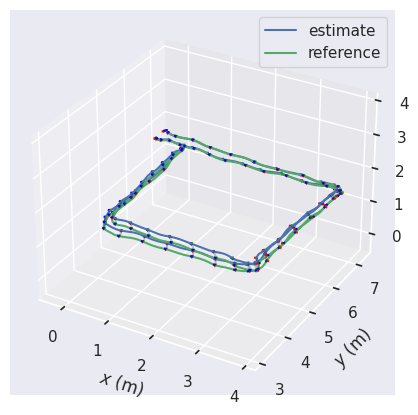

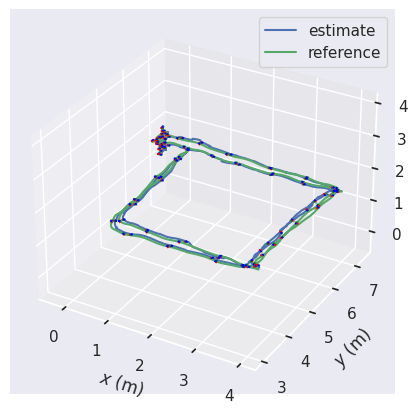

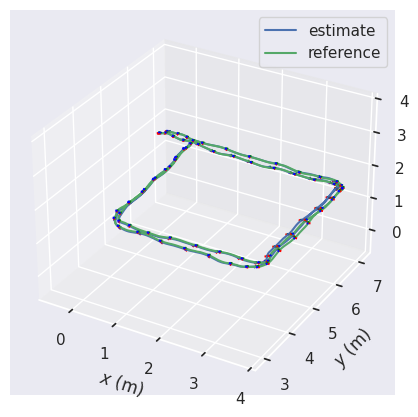

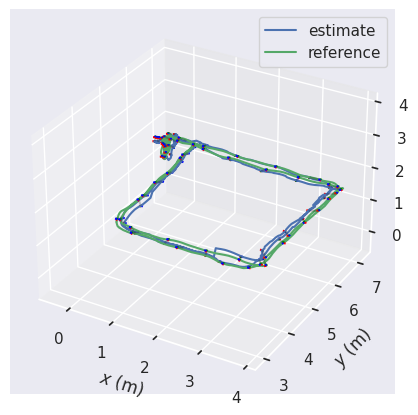

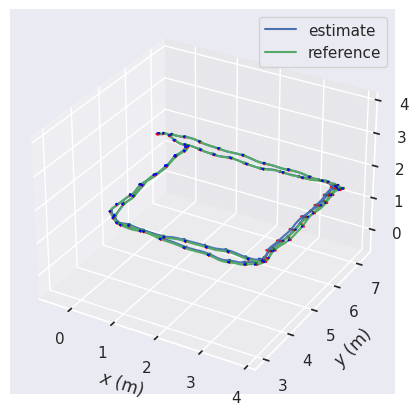

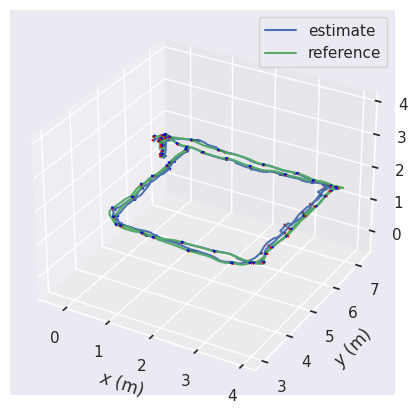

In [8]:
RPE_values = np.zeros(len(traj_folders))
APE_values = np.zeros(len(traj_folders))
Speed_values  =  np.zeros(len(traj_folders))
ORB_RPE_values = np.zeros(len(traj_folders))
ORB_APE_values = np.zeros(len(traj_folders))


for i, traj_folder in enumerate(traj_folders):
    try:
        traj_gt = read_tum_trajectory_file(f"./{traj_folder}/gt.txt")
        traj_orb = read_tum_trajectory_file(f"./{traj_folder}/orb.txt")
        traj_xr = read_tum_trajectory_file(f"./{traj_folder}/xr.txt")

        traj_gt = utils.check_monotionic_increaseing(traj_gt)
        traj_gt = utils.check_gt_abnormal_traj(traj_gt, speed_threshold=2)
        traj_orb = utils.check_monotionic_increaseing(traj_orb, type='orb')
        traj_xr = utils.check_monotionic_increaseing(traj_xr, type='xr')

        if device == 'Quest':
            traj_gt_xr = utils.get_Quest_traj_from_gt(traj_gt)
        else:
            traj_gt_xr = utils.get_AVP_traj_from_gt(traj_gt)

        traj_gt_xr_copy = copy.deepcopy(traj_gt_xr)
        #traj_gt_copy = copy.deepcopy(traj_gt)
        traj_xr_copy = copy.deepcopy(traj_xr)
        #best_offset = utils.find_traj_est_offset(traj_xr, traj_gt_xr_copy, iter=8, lower=-0.5, upper=0.5)
        best_offset = 0#+0.005
        print(f"best_offset: {best_offset} ")

        traj_gt_xr_copy, traj_xr_copy = align_trajectory(traj_gt_xr_copy, traj_xr_copy, best_offset)
        rpe = utils.calculate_RE(traj_xr_copy, traj_gt_xr_copy, est_offset=0)
        #rpe = calculate_RE(traj_orb_copy, traj_gt, est_offset=0)
        RPE_values[i] = np.mean(rpe.error)
        
        fig = plt.figure()
        plt.plot(rpe.delta_ids, rpe.error)
        fig.savefig('./{}/{}.png'.format(traj_folder, "RPE_Error"))
        plt.close(fig)
        

        plot_trajectory(traj_xr_copy, traj_gt_xr_copy, traj_folder, "xr_trajectory")

        traj_gt_xr_copy, traj_xr_copy = align_trajectory(traj_gt_xr_copy, traj_xr_copy, best_offset)
        ape = utils.calculate_APE(traj_xr_copy, traj_gt_xr_copy, est_offset=0)
        ape_stat = ape.get_statistic(metrics.StatisticsType.rmse)
        APE_values[i] = ape_stat

        traj_xr_copy = copy.deepcopy(traj_xr)
        traj_xr_copy = utils.check_monotionic_increaseing(traj_xr_copy)
        print(f"Speed - {np.nanmean(traj_xr_copy.speeds)}")
        Speed_values[i] = np.nanmean(traj_xr_copy.speeds)


        traj_gt_copy = copy.deepcopy(traj_gt)
        traj_orb_copy = copy.deepcopy(traj_orb)
        traj_orb_copy, traj_ref_copy = utils.check_orb_abnormal_traj(traj_orb_copy, 
                                                                     traj_gt_copy,
                                                                     speed_threshold=10)
        #traj_gt_copy = copy.deepcopy(traj_gt)
        plot_trajectory(traj_orb_copy, traj_gt_copy, traj_folder, "orb_trajectory")

        rpe = utils.calculate_RE(traj_orb_copy, traj_ref_copy, est_offset=0)
        #rpe = calculate_RE(traj_orb_copy, traj_gt, est_offset=0)
        ORB_RPE_values[i] = np.mean(rpe.error)

        ape = utils.calculate_APE(traj_ref_copy, traj_orb_copy, est_offset=0)
        ape_stat = ape.get_statistic(metrics.StatisticsType.rmse)
        ORB_APE_values[i] = ape_stat

    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print(f"{traj_folder} failed!")
    else:
        pass


In [9]:
print(f"Traj   \t|  RPE_values \t|  APE_values \t|  Speed \t| ORB_RPE \t| ORB_ATE")

for i, traj_folder in enumerate(traj_folders):
    print(f"{traj_folder}\t|  {RPE_values[i]:.6f}\t|  {APE_values[i]:.6f}\t|  {Speed_values[i]:.6f}\t|  {ORB_RPE_values[i]:.6f}\t|  {ORB_APE_values[i]:.6f}")

Traj   	|  RPE_values 	|  APE_values 	|  Speed 	| ORB_RPE 	| ORB_ATE
T1	|  0.005784	|  0.109902	|  0.993083	|  0.010931	|  0.129584
T2	|  0.006753	|  0.106007	|  1.080430	|  0.015158	|  0.132222
T3	|  0.006415	|  0.084930	|  1.017545	|  0.010496	|  0.091551
